In [1]:
import math
import json
import warnings
import numpy as np
import pandas as pd
import csv
import copy
import matplotlib.pyplot as plt

from collections import OrderedDict
from IPython.display import display, HTML

from cryptorandom.cryptorandom import SHA256, int_from_hash
from cryptorandom.sample import sample_by_index

from Audit import Audit, Assertion, Assorter, Contest, CVR, Stratum
from NonnegMean import NonnegMean
from Dominion import Dominion
from Hart import Hart

In [7]:
audit = Audit.from_dict({
         'seed':           12345678901234567890,
         'sim_seed':       314159265,
         'cvr_file':       '/Users/amanda/Downloads/oc_cvrs.zip', 
         #'cvr_file':       '/Users/Jake/Desktop/oc_cvrs.zip', 
         'manifest_file': 'Data/OC_full_manifest.xlsx',
         #'manifest_file': 'tests/Data/Hart_manifest.xlsx',
         'sample_file':    '',
         'mvr_file':       '',
         'log_file':       'Data/OC_example_log.json',
         'quantile':       0.8,
         'error_rate_1': 0,
         'error_rate_2': 0,
         #'error_rate_1':   0.001,
         #'error_rate_2':   0.0001,
         'reps':           100,
         'strata':         {'stratum_1': {'max_cards':   3094308, 
                                          'use_style':   False,
                                          'replacement': False,
                                          'audit_type':  Audit.AUDIT_TYPE.BALLOT_COMPARISON,
                                          'test':        NonnegMean.alpha_mart,
                                          'estimator':   NonnegMean.optimal_comparison,
                                          'test_kwargs': {}
                                         }
                           }
        })

# find upper bound on total cards across strata
audit.max_cards = np.sum([s.max_cards for s in audit.strata.values()])

In [4]:
%%time
#cvr_zip = "/Users/Jake/Desktop/oc_cvrs.zip"
cvr_zip = "/Users/amanda/Downloads/oc_cvrs.zip"

cvr_list = Hart.read_cvrs_zip(cvr_zip) # all CVRs

CPU times: user 10min 36s, sys: 9.61 s, total: 10min 46s
Wall time: 10min 46s


In [5]:
votes = CVR.tabulate_votes(cvr_list)
styles = CVR.tabulate_styles(cvr_list)
cards = CVR.tabulate_cards_contests(cvr_list)

In [8]:
# make dict of all contests in CVRs
contests = Contest.from_cvr_list(audit, votes, cards, cvr_list)

In [9]:
# Create array of vote for 2 contests
vote_for_two = ['LAGUNA BEACH UNIFIED SCHOOL DISTRICT\nGoverning Board Member', 
               'HUNTINGTON BEACH UNION HIGH SCHOOL DISTRICT\nGoverning Board Member', 
               'FOUNTAIN VALLEY SCHOOL DISTRICT\nGoverning Board Member', 
               'LA HABRA CITY SCHOOL DISTRICT\nGoverning Board Member,\nFull Term',
               'CITY OF BREA\nMember, City Council', 
               'CITY OF CYPRESS\nMember, City Council', 
               'CITY OF FOUNTAIN VALLEY\nMember, City Council',
                'CITY OF LAGUNA BEACH\nMember, City Council',
                'CITY OF LAGUNA HILLS\nMember, City Council',
                'CITY OF MISSION VIEJO\nMember, City Council,\nTwo-Year Term',
                'RANCHO SANTA MARGARITA\nMember, City Council',
                'CITY OF SAN CLEMENTE\nMember, City Council, Full Term', 
                'CAPISTRANO BAY COMMUNITY SERVICES DISTRICT\nDirector',
                'SILVERADO-MODJESKA RECREATION AND PARK DISTRICT\nDirector',
                'MIDWAY CITY SANITARY DISTRICT\nDirector',
                'SURFSIDE COLONY STORM WATER PROTECTION DISTRICT\nTrustee',
                'EAST ORANGE COUNTY WATER DISTRICT\nDirector',
                'SANTIAGO GEOLOGIC HAZARD ABATEMENT DISTRICT\nDirector, Full Term'
               ]
# Create array of vote for 3 contests
vote_for_three = ['SANTA ANA UNIFIED SCHOOL DISTRICT\nGoverning Board Member',
                  'CITY OF ALISO VIEJO\nMember, City Council',
                  'CITY OF HUNTINGTON BEACH\nMember, City Council',
                  'CITY OF IRVINE\nMember, City Council',
                  'CITY OF LAGUNA NIGUEL\nMember, City Council',
                  'CITY OF LAGUNA WOODS\nMember, City Council',
                  'CITY OF LA HABRA\nMember, City Council', 
                  'CITY OF LA PALMA\nMember, City Council',
                  'CITY OF TUSTIN\nMember, City Council',
                  'ROSSMOOR COMMUNITY SERVICES DISTRICT\nDirector, Full Term',
                  'SUNSET BEACH SANITARY DISTRICT\nDirector, Full Term',
                  'SANTA MARGARITA WATER DISTRICT\nDirector', 
                  'SOUTH COAST WATER DISTRICT\nDirector',
                  'BUENA PARK LIBRARY DISTRICT\nTrustee'
                 ]
# Update dictionary with correct n_winners
for con in vote_for_two:
    contests[con].n_winners = 2
    
for con in vote_for_three:
    contests[con].n_winners = 3

In [10]:
## Fix winners lists
contests['LAGUNA BEACH UNIFIED SCHOOL DISTRICT\nGoverning Board Member'].winner = ['KELLY OSBORNE', 'JAN VICKERS']
contests['HUNTINGTON BEACH UNION HIGH SCHOOL DISTRICT\nGoverning Board Member'].winner = ['SUSAN HENRY', 'MICHAEL SIMONS']
contests['FOUNTAIN VALLEY SCHOOL DISTRICT\nGoverning Board Member'].winner = ['STEVE SCHULTZ', 'JEANNE GALINDO']
contests['LA HABRA CITY SCHOOL DISTRICT\nGoverning Board Member,\nFull Term'].winner = ['SUSAN M. PRITCHARD', 'OFELIA CORONA HANSON']
contests['CITY OF BREA\nMember, City Council'].winner = ['CHRISTINE MARICK', 'MARTY SIMONOFF']
contests['CITY OF CYPRESS\nMember, City Council'].winner = ['ANNE HERTZ', 'FRANCES MARQUEZ']
contests['CITY OF FOUNTAIN VALLEY\nMember, City Council'].winner = ['GLENN GRANDIS', 'TED BUI']
contests['CITY OF LAGUNA BEACH\nMember, City Council'].winner = ['BOB WHALEN', 'GEORGE WEISS']
contests['CITY OF LAGUNA HILLS\nMember, City Council'].winner = ['JANINE HEFT', 'BILL HUNT']
contests['CITY OF MISSION VIEJO\nMember, City Council,\nTwo-Year Term'].winner = ['PATRICIA "TRISH" KELLEY', 'BRIAN GOODELL']
contests['RANCHO SANTA MARGARITA\nMember, City Council'].winner = ['TONY BEALL', 'CAROL GAMBLE']
contests['CITY OF SAN CLEMENTE\nMember, City Council, Full Term'].winner = ['GENE JAMES', 'CHRIS DUNCAN'] 
contests['CAPISTRANO BAY COMMUNITY SERVICES DISTRICT\nDirector'].winner = ['BRAD L. JENKINS', 'WILLIAM WIERSIG']
contests['SILVERADO-MODJESKA RECREATION AND PARK DISTRICT\nDirector'].winner = ['MICHELE GRACE AGOPIAN', 'JULIE A. MORRIS']
contests['MIDWAY CITY SANITARY DISTRICT\nDirector'].winner = ['CHI CHARLIE NGUYEN', 'TYLER DIEP']
# double check surfside winners..
contests['SURFSIDE COLONY STORM WATER PROTECTION DISTRICT\nTrustee'].winner = ['DAVE CHAMBERLAIN', 'VICTOR J. KRISS']
contests['EAST ORANGE COUNTY WATER DISTRICT\nDirector'].winner = ['DOUGLASS S. DAVERT', 'JOHN L SEARS']
contests['SANTIAGO GEOLOGIC HAZARD ABATEMENT DISTRICT\nDirector, Full Term'].winner = ['JAMES GUZIAK', 'CRAIG S. SCHILL']

contests['SANTA ANA UNIFIED SCHOOL DISTRICT\nGoverning Board Member'].winner = ['CAROLYN TORRES', 'RIGO RODRIGUEZ', 'ALFONSO ALVAREZ']
contests['CITY OF ALISO VIEJO\nMember, City Council'].winner = ['MIKE MUNZING', 'ROSS CHUN', 'RICHARD HURT']
contests['CITY OF HUNTINGTON BEACH\nMember, City Council'].winner = ['TITO ORTIZ', 'DAN KALMICK', 'NATALIE MOSER']
contests['CITY OF IRVINE\nMember, City Council'].winner = ['TAMMY KIM', 'MIKE CARROLL', 'LARRY AGRAN']
contests['CITY OF LAGUNA NIGUEL\nMember, City Council'].winner = ['SANDY RAINS', 'RISCHI PAUL SHARMA', 'KELLY JENNINGS']
contests['CITY OF LAGUNA WOODS\nMember, City Council'].winner = ['NOEL HATCH', 'SHARI L HORNE', 'CYNTHIA CONNERS']
contests['CITY OF LA HABRA\nMember, City Council'].winner = ['ROSE ESPINOZA', 'TIM SHAW', 'STEVE SIMONIAN']
contests['CITY OF LA PALMA\nMember, City Council'].winner = ['MARSHALL GOODMAN', 'DEBBIE BAKER', 'MARK I. WALDMAN']
contests['CITY OF TUSTIN\nMember, City Council'].winner = ['LETITIA CLARK', 'REBECCA "BECKIE" GOMEZ', 'RYAN GALLAGHER']
contests['ROSSMOOR COMMUNITY SERVICES DISTRICT\nDirector, Full Term'].winner = ['JEFFREY BARKE', 'TONY DEMARCO', 'NATHAN SEARLES']
contests['SUNSET BEACH SANITARY DISTRICT\nDirector, Full Term'].winner = ['DAVID EVANS', 'JOHN H. WOODS', 'JON H. REGNIER']
contests['SANTA MARGARITA WATER DISTRICT\nDirector'].winner = ['CHARLES "CHUCK" GIBSON', 'BETTY H. OLSON', 'FRANK URY']
contests['SOUTH COAST WATER DISTRICT\nDirector'].winner = ['RICK ERKENEFF', 'SCOTT GOLDMAN', 'DOUGLAS ERDMAN']
contests['BUENA PARK LIBRARY DISTRICT\nTrustee'].winner = ['PATRICIA GANER', 'IRENE CASTANEDA', 'L CAROLE JENSEN']

In [11]:
# construct the dict of dicts of assertions for each contest
Assertion.make_all_assertions(contests)

True

In [12]:
audit.check_audit_parameters(contests)

## Read the ballot manifest

In [13]:
manifest = pd.read_excel(audit.manifest_file)

In [14]:
manifest.head()

,Batch Name,Number of Ballots,Container,Tabulator,cum_cards
0,274,2829,1,99808,2829
1,0,523869,1,99808,526698
2,140,9333,1,99808,536031
3,106,10762,1,99808,546793
4,124,10067,1,99808,556860


In [15]:
# check whether the manifest accounts for every card
# it doesn't because phantoms 
audit.max_cards, np.sum(manifest['Number of Ballots'].astype(int))

(3094308, 3094308)

In [16]:
# Check that there is a card in the manifest for every card (possibly) cast. If not, add phantoms.
manifest, manifest_cards, phantom_cards = Hart.prep_manifest(manifest, audit.max_cards, len(cvr_list))

In [17]:
## NOTE: for some reason prep manifest turns all the columns into string type..
audit.max_cards, np.sum(manifest['Number of Ballots'].astype(int))

(3094308, 3094308)

## Create CVRs for phantom cards

In [18]:
# For Comparison Audits Only
#----------------------------

# If the sample draws a phantom card, these CVRs will be used in the comparison.
# phantom MVRs should be treated as zeros by the Assorter for every contest

# setting use_style = False to generate phantoms

cvr_list, phantom_vrs = CVR.make_phantoms(audit=audit, contests=contests, 
                                          cvr_list=cvr_list, prefix='phantom-1-')
print(f"Created {phantom_vrs} phantom records")

Created 0 phantom records


In [19]:
%%time
# find the mean of the assorters for the CVRs and check whether the assertions are met
# this takes a very long time to run on all contests
min_margin = Assertion.set_all_margins_from_cvrs(audit=audit, contests=contests, 
                                                 cvr_list=cvr_list)

print(f'minimum assorter margin {min_margin}')
Contest.print_margins(contests)

minimum assorter margin 3.2317403442228e-07
margins in contest Proposition 19:
	assertion No v Yes: 0.0314939559992089
margins in contest Proposition 20:
	assertion No v Yes: 0.07456109734389726
margins in contest Proposition 21:
	assertion No v Yes: 0.15260439490832844
margins in contest Proposition 22:
	assertion Yes v No: 0.1529711974373591
margins in contest Proposition 23:
	assertion No v Yes: 0.16086601592343097
margins in contest Proposition 24:
	assertion Yes v No: 0.03800494327003001
margins in contest Proposition 25:
	assertion No v Yes: 0.10177978404218324
margins in contest AA-City of Orange:
	assertion No v Yes: 0.005351438835435873
margins in contest Proposition 14:
	assertion No v Yes: 0.0381603899805707
margins in contest Proposition 15:
	assertion No v Yes: 0.10148989693333688
margins in contest Proposition 16:
	assertion No v Yes: 0.14629733045320625
margins in contest Proposition 17:
	assertion No v Yes: 0.002109356922452399
margins in contest Proposition 18:
	assert

In [20]:
audit.write_audit_parameters(contests=contests) 

## Set up for sampling

## Find initial sample size

In [22]:
len(cvr_list)

3094308

In [21]:
%%time
# find initial sample size 
# error here, there are some CVRs that aren't receiving a p, 
# which then causes an error when they are summed over. 
# See line 746-749 in Audit.py;
# one fix is to set the p for CVRs not in the contest to 0; 
# another is to skip counting them in the sum...
sample_size = audit.find_sample_size(contests, cvrs=cvr_list)  
print(f'{sample_size=}\n{[(i, c.sample_size) for i, c in contests.items()]}')

sample_size=3094308
[('Proposition 19', 190), ('Proposition 20', 80), ('Proposition 21', 38), ('Proposition 22', 38), ('Proposition 23', 36), ('Proposition 24', 157), ('Proposition 25', 58), ('AA-City of Orange', 1162), ('Proposition 14', 157), ('Proposition 15', 58), ('Proposition 16', 40), ('Proposition 17', 3135), ('Proposition 18', 43), ('Z-City of Newport Beach', 4333), ('CC-City of Tustin', 1226), ('S-City of Fullerton', 2211), ('U-City of Fullerton', 1577), ('DD-City of Westminster', 929), ('Y-City of Los Alamitos', 3094254), ('Q-City of Costa Mesa', 1245), ('P-City of Cypress', 2238), ('BB-City of San Clemente', 956), ('W-City of La Habra', 2165), ('X-City of La Habra', 1482), ('V-City of Laguna Woods', 3094197), ('ORANGE COUNTY WATER DISTRICT\nDirector, Division 4', 854), ('MUNICIPAL WATER DISTRICT OF ORANGE COUNTY\nDirector, Division 3', 823), ('ORANGE COUNTY WATER DISTRICT\nDirector, Division 6', 835), ('CITY OF GARDEN GROVE\nMayor', 879), ('IRVINE RANCH WATER DISTRICT\nDire

In [42]:
print(contests['CITY OF LOS ALAMITOS\nMember, City Council, District 2'])

{'id': 'CITY OF LOS ALAMITOS\nMember, City Council, District 2', 'name': 'CITY OF LOS ALAMITOS\nMember, City Council, District 2', 'risk_limit': 0.05, 'cards': 3094308, 'choice_function': 'PLURALITY', 'n_winners': 1, 'share_to_win': None, 'candidates': ['KATE HALLMAN', 'RON BATES', 'WRITE_IN'], 'winner': ['RON BATES'], 'assertion_file': None, 'audit_type': 'BALLOT_COMPARISON', 'test': <function NonnegMean.alpha_mart at 0x7fadd1c40700>, 'g': 0.1, 'estim': <function NonnegMean.optimal_comparison at 0x7fadd1c40af0>, 'use_style': False, 'assertions': {'RON BATES v KATE HALLMAN': <Audit.Assertion object at 0x7fad3e039130>, 'RON BATES v WRITE_IN': <Audit.Assertion object at 0x7fad3e039220>}, 'tally': None, 'sample_size': 3094116, 'cvrs': 1220, 'margins': {'RON BATES v KATE HALLMAN': 0.00012506835130832172, 'RON BATES v WRITE_IN': 0.00024108782965370779}}


In [29]:
# Gather sampling data
contest_names = []
contest_cards = []
contest_sample_sizes = []
sampling_fractions = []
for c in contests:
    contest_names.append(c)
    contest_cards.append(contests[c].cvrs)
    contest_sample_sizes.append(contests[c].sample_size)
    sampling_fractions.append(contests[c].sample_size / contests[c].cards)

In [50]:
sum(contests[c].sample_size > 3094308*0.99 for c in contests)

27

Text(0.5, 1.0, 'OC November 2020 RLA Without Style')

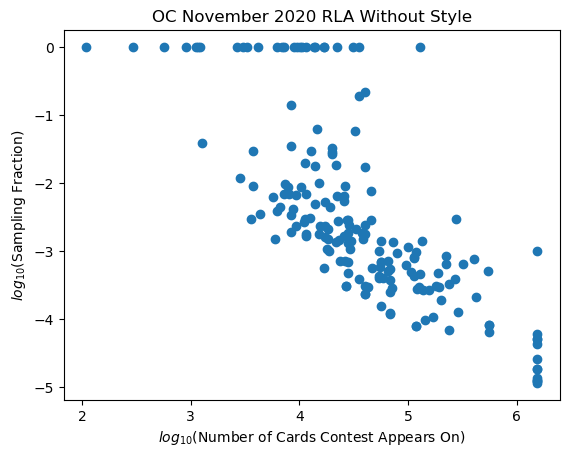

In [51]:
# Plot
plt.scatter(np.log10(contest_cards), np.log10(sampling_fractions))
plt.xlabel("$log_{10}($Number of Cards Contest Appears On$)$")
plt.ylabel("$log_{10}($Sampling Fraction$)$")
plt.title("OC November 2020 RLA Without Style")